# Bgee

Extracting data from [Bgee](http://bgee.unil.ch/). See [this Thinklab discussion](http://thinklab.com/discussion/tissue-specific-gene-expression-resources/81#278) for more information.

In [1]:
import collections
import gzip

import pandas
import seaborn
import numpy
import matplotlib.pyplot as plt
import IPython

%matplotlib inline

In [2]:
def get_groupby_counts(df, columns):
    """Group datagrame by columns and return the number of rows for each grouping."""
    grouped = df.groupby(columns)
    get_len = lambda df: pandas.Series({'count': len(df)})
    df = grouped.apply(get_len)
    df = df.sort('count', ascending=False)
    df = df.reset_index()
    return df

## Load entrez gene for ensembl conversion

In [44]:
# Read Entrez Genes
url = 'https://raw.githubusercontent.com/dhimmel/entrez-gene/6e133f9ef8ce51a4c5387e58a6cc97564a66cec8/data/genes-human.tsv'
entrez_df = pandas.read_table(url)
coding_genes = set(entrez_df.GeneID[entrez_df.type_of_gene == 'protein-coding'])

# Merge with entrez gene identifiers
url = 'https://raw.githubusercontent.com/dhimmel/entrez-gene/6e133f9ef8ce51a4c5387e58a6cc97564a66cec8/data/xrefs-human.tsv'
entrez_map_df = pandas.read_table(url)    
entrez_map_df = entrez_map_df[entrez_map_df.resource == 'Ensembl']

ensembl_to_entrez = dict(zip(entrez_map_df.identifier, entrez_map_df.GeneID))

## Read and process presence of expression data

In [30]:
# Read expression
presence_df = pandas.read_table('download/Homo_sapiens_expr-complete.tsv.gz', compression='gzip')
presence_df.head()

,Gene ID,Gene name,Anatomical entity ID,Anatomical entity name,Developmental stage ID,Developmental stage name,Expression,Call quality,Including observed data,Affymetrix data,...,Including Affymetrix observed data,EST data,EST call quality,Including EST observed data,In situ data,In situ call quality,Including in situ observed data,RNA-Seq data,RNA-Seq call quality,Including RNA-Seq observed data
0,ENSG00000000003,TSPAN6,CL:0000000,cell,HsapDv:0000087,human adult stage (human),present,high quality,no,present,...,no,no data,no data,no,no data,no data,no,no data,no data,no
1,ENSG00000000003,TSPAN6,CL:0000000,cell,HsapDv:0000088,human early adulthood stage (human),present,high quality,no,present,...,no,no data,no data,no,no data,no data,no,no data,no data,no
2,ENSG00000000003,TSPAN6,CL:0000000,cell,HsapDv:0000089,young adult stage (human),present,high quality,no,present,...,no,no data,no data,no,no data,no data,no,no data,no data,no
3,ENSG00000000003,TSPAN6,CL:0000000,cell,HsapDv:0000090,25-44 year-old human stage (human),present,high quality,no,present,...,no,no data,no data,no,no data,no data,no,no data,no data,no
4,ENSG00000000003,TSPAN6,CL:0000000,cell,HsapDv:0000091,human late adulthood stage (human),present,high quality,no,present,...,no,no data,no data,no,no data,no data,no,no data,no data,no


In [31]:
# Apply filters for gene presence
present_df = presence_df[
    presence_df['Call quality'].isin({'high quality', 'low quality'}) &
    presence_df['Expression'].isin({'present', 'low ambiguity'})
]

In [32]:
# Find genes present per developmental stage
stage_df = get_groupby_counts(present_df, ['Developmental stage ID', 'Developmental stage name'])
stage_df.head(12)

,Developmental stage ID,Developmental stage name,count
0,UBERON:0000104,life cycle,7270053
1,UBERON:0000066,fully formed stage,6847848
2,UBERON:0000092,post-embryonic stage,6847848
3,UBERON:0000113,post-juvenile adult stage,6722450
4,HsapDv:0000087,human adult stage (human),6430153
5,HsapDv:0000088,human early adulthood stage (human),5094102
6,HsapDv:0000091,human late adulthood stage (human),5051786
7,HsapDv:0000090,25-44 year-old human stage (human),4821586
8,HsapDv:0000092,human middle aged stage (human),4311395
9,HsapDv:0000093,human aged stage (human),3371418


In [34]:
# Find genes present per anatomical entity
anatomy_df = get_groupby_counts(present_df, ['Anatomical entity ID', 'Anatomical entity name'])
anatomy_df.head(10)

,Anatomical entity ID,Anatomical entity name,count
0,UBERON:0001062,anatomical entity,613385
1,UBERON:0000061,anatomical structure,613367
2,UBERON:0000468,multi-cellular organism,612546
3,UBERON:0000467,anatomical system,580567
4,UBERON:0000064,organ part,452218
5,UBERON:0000990,reproductive system,414926
6,UBERON:0005156,reproductive structure,414926
7,UBERON:0001016,nervous system,411851
8,UBERON:0000475,organism subdivision,410747
9,UBERON:0001017,central nervous system,410621


### Figure 1: Number of genes present by developmental stage and anatomical entity

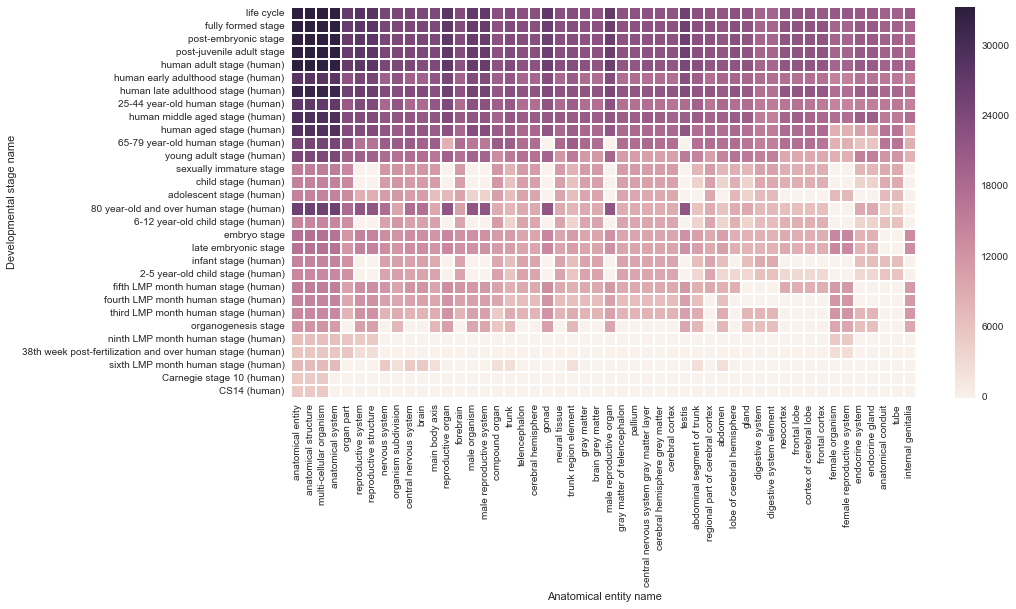

In [66]:
# Number of present genes per development stage -- anatomical entity pair
pairwise_df = get_groupby_counts(present_df, ['Developmental stage name', 'Anatomical entity name'])
rect_df = pairwise_df.pivot('Developmental stage name', 'Anatomical entity name', 'count').fillna(0)
rect_df = rect_df.loc[stage_df['Developmental stage name'][:30], anatomy_df['Anatomical entity name'][:50]]
IPython.core.pylabtools.figsize(14, 7)
seaborn.heatmap(rect_df);

In [63]:
# filter to human adult stage (human)
adult_df = present_df[present_df['Developmental stage ID'] == 'HsapDv:0000087']

# pivot dataframe so each column is an anatomical entity
adult_df = adult_df.pivot('Gene ID', 'Anatomical entity ID', 'Expression')
adult_df = (adult_df == 'present').astype(int)

# convert to entrez GeneIDs
adult_df = adult_df.groupby(ensembl_to_entrez).max()
adult_df = adult_df.reset_index()
adult_df = adult_df.rename(columns=({'index': 'GeneID'}))
adult_df.GeneID = adult_df.GeneID.astype(int)

# save dataframe
with gzip.open('data/present-in-adult.tsv.gz', 'wt') as write_file:
    adult_df.to_csv(write_file, sep='\t', index=False)

# see tail
adult_df.tail()

Anatomical entity ID,GeneID,CL:0000000,CL:0000015,CL:0000019,CL:0000021,CL:0000023,CL:0000064,CL:0000066,CL:0000083,CL:0000115,...,UBERON:0016526,UBERON:0016529,UBERON:0016538,UBERON:0016548,UBERON:0016887,UBERON:0017672,UBERON:0018254,UBERON:0018260,UBERON:0018674,UBERON:3000961
18992,105378753,0,0,0,0,0,0,0,0,0,...,1,1,0,1,0,0,0,0,0,0
18993,105378933,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18994,105378966,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18995,105379030,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18996,105379175,0,0,0,0,0,0,0,0,0,...,1,1,0,1,0,0,0,0,0,0


In [64]:
# Coding genes in entrez dataset
len(set(adult_df.GeneID) & coding_genes)

16278

In [83]:
# Frequency of gene presence 
adult_df.drop('GeneID', 1).as_matrix().mean()

0.41120029857725282

## Read and process differential expression data

In [18]:
# Read simple differential expression by anatomy
diffex_df = pandas.read_table('download/Homo_sapiens_diffexpr-anatomy-simple.tsv.gz', compression='gzip')
diffex_df.head()

,Gene ID,Gene name,Anatomical entity ID,Anatomical entity name,Developmental stage ID,Developmental stage name,Differential expression,Call quality
0,ENSG00000000003,TSPAN6,CL:0000015,male germ cell,UBERON:0000113,post-juvenile adult stage,over-expression,low quality
1,ENSG00000000003,TSPAN6,CL:0000738,leukocyte,UBERON:0000113,post-juvenile adult stage,under-expression,high quality
2,ENSG00000000003,TSPAN6,UBERON:0000002,uterine cervix,UBERON:0000113,post-juvenile adult stage,over-expression,high quality
3,ENSG00000000003,TSPAN6,UBERON:0000007,pituitary gland,UBERON:0000113,post-juvenile adult stage,over-expression,high quality
4,ENSG00000000003,TSPAN6,UBERON:0000029,lymph node,UBERON:0000113,post-juvenile adult stage,under-expression,high quality


In [20]:
# filter differential expression
diffex_df = diffex_df[
    diffex_df['Differential expression'].isin({'over-expression', 'under-expression'}) &
    diffex_df['Call quality'].isin({'low quality', 'high quality'})
]

In [21]:
# Calculate counts per anatomy--DE pair
de_anatomy_df = get_groupby_counts(diffex_df, ['Anatomical entity ID', 'Anatomical entity name', 'Differential expression'])
de_anatomy_df.head()

,Anatomical entity ID,Anatomical entity name,Differential expression,count
0,CL:0000738,leukocyte,under-expression,12406
1,UBERON:0000473,testis,over-expression,10267
2,UBERON:0002369,adrenal gland,over-expression,9079
3,UBERON:0000955,brain,over-expression,8485
4,UBERON:0002369,adrenal gland,under-expression,7989


### Figure 2: Number of differntially expressed genes present by anatomical entity

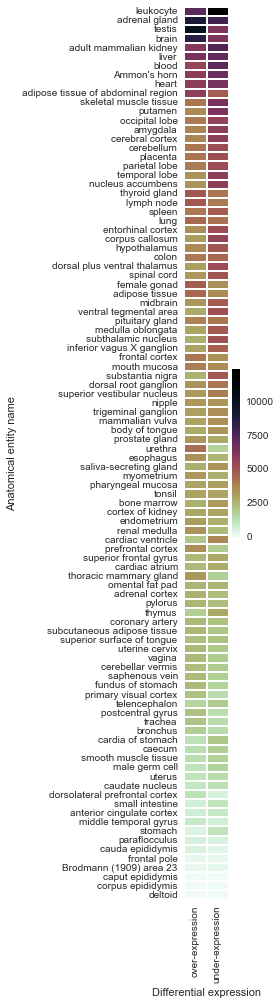

In [29]:
# Plot DE counts
rect_df = de_anatomy_df.pivot('Anatomical entity name', 'Differential expression', 'count').fillna(0)
rect_df['differential expression'] = rect_df['under-expression'] + rect_df['over-expression']
rect_df = rect_df.sort('differential expression', ascending=False)
IPython.core.pylabtools.figsize(1, 16)
cmap = seaborn.cubehelix_palette(15, start=2.2, rot=1, gamma=1.6, hue=1, light=0.98, dark=0, as_cmap=True)
seaborn.heatmap(rect_df.drop('differential expression', axis=1), cmap=cmap);

In [73]:
diffex_pivot_df = diffex_df.pivot('Gene ID', 'Anatomical entity ID', 'Differential expression')
diffex_pivot_df = diffex_pivot_df.replace({'under-expression': -1, 'over-expression': 1, numpy.NaN: 0})

In [74]:
def round_diffex(value):
    if value <= -0.5:
        return -1
    if value >= 0.5:
        return 1
    return 0

diffex_pivot_df = diffex_pivot_df.groupby(ensembl_to_entrez).mean().applymap(round_diffex)

In [75]:
diffex_pivot_df = diffex_pivot_df.reset_index()
diffex_pivot_df = diffex_pivot_df.rename(columns=({'index': 'GeneID'}))
diffex_pivot_df.GeneID = diffex_pivot_df.GeneID.astype(int)

# save dataframe
with gzip.open('data/diffex.tsv.gz', 'wt') as write_file:
    diffex_pivot_df.to_csv(write_file, sep='\t', index=False)

# see tail
diffex_pivot_df.tail()

Anatomical entity ID,GeneID,CL:0000015,CL:0000738,UBERON:0000002,UBERON:0000007,UBERON:0000029,UBERON:0000044,UBERON:0000057,UBERON:0000082,UBERON:0000178,...,UBERON:0005363,UBERON:0007227,UBERON:0007318,UBERON:0007371,UBERON:0007808,UBERON:0009834,UBERON:0009835,UBERON:0010414,UBERON:0011876,UBERON:0013554
18615,105378753,0,0,0,0,-1,0,0,-1,0,...,0,0,0,0,0,0,0,0,0,0
18616,105378933,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18617,105378966,0,0,0,0,0,0,0,-1,0,...,0,0,0,0,0,0,0,0,0,0
18618,105379030,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
18619,105379175,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [76]:
# Coding genes in entrez dataset
len(set(diffex_pivot_df.GeneID) & coding_genes)

16184

## GNF Expression Atlas (BodyMap) expression counts

Show the presence counts per tissue we observed in the [GNF Expression Atlas](https://dx.doi.org/10.1073/pnas.0400782101) data.

In [14]:
import io
import requests
import numpy

# Read BTO id and names
url = 'https://gist.githubusercontent.com/dhimmel/1f252b674c0c75443cc1/raw/a97c3425792f2288b0369de70e1b46018832455b/bto-terms-in-gnf.tsv'
bto_df = pandas.read_table(url)

# Read expression
url = 'http://het.io/disease-genes/downloads/files/expression.txt.gz'
with gzip.open(io.BytesIO(requests.get(url).content)) as read_file:
    gnf_df = pandas.read_table(read_file)
gnf_df = numpy.log10(gnf_df)

In [15]:
# Compute expressed genes per tissue
gnf_summary_df = (gnf_df >= 1.4).sum().reset_index()
gnf_summary_df.columns = ['bto_id', 'count']
gnf_summary_df = bto_df.merge(gnf_summary_df, how='right')
gnf_summary_df = gnf_summary_df.sort('count', ascending=False)
gnf_summary_df.head(15)

,bto_id,bto_name,cell_line,count
72,BTO:0003335,EBV-LCL cell,1,5138
19,BTO:0000725,hematopoietic stem cell,0,4996
28,BTO:0000914,natural killer cell,0,4883
75,BTO:0004730,myeloid progenitor cell,0,4823
36,BTO:0001067,pineal gland,0,4799
65,BTO:0002042,dendritic cell,0,4782
43,BTO:0001175,retina,0,4631
70,BTO:0002807,prefrontal cortex,0,4566
58,BTO:0001379,thyroid gland,0,4534
24,BTO:0000776,B-lymphocyte,0,4415


### Figure 3: Distibution of genes present per tissue in GNF Expression Atlas

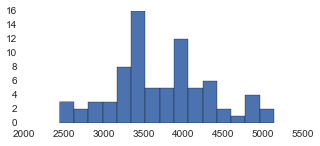

In [16]:
# Plot distribution of expressed genes per tissue
IPython.core.pylabtools.figsize(5, 2)
plt.hist(gnf_summary_df['count'], 15);